<h1 style="text-align:center;font-size:30px;" > Case Study- ELO MERCHANT CATEGORY RECOMMENDATION

<h1> 1. Business Problem </h1>

<h3> 1.1 Description </h3>

<p>Elo is one of the biggest and most relaible payment brand in brazil, It planned a reward program to attract the customers based on customers loyalty score.

<h3> 1.2 Problem statement </h3>

<p>Elo wants to predict customers' loyalty based on the given features so they can give more offers to loyal customers which will be in favour of customers and merchants as well. (so they can target individual customers and avoid unnecessary campaigns).
<p>It seems like a recommendation but here we have to predict customers’ loyalty score which is nothing but real value. So this is problem of regression</p>



<h3> 1.3 Sources/Useful Link/Credits </h3>

Source: https://www.kaggle.com/c/elo-merchant-category-recommendation/overview <br>
https://www.kaggle.com/praxitelisk/elo-eda-ml<br>
https://www.kaggle.com/pedroforli/elo-data-engineering   <br>
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82127<br>
https://www.kaggle.com/batalov/making-sense-of-elo-data-eda<br>
https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending<br>

<h3>1.4 Real world/Business Objectives and Constraints </h3>

<ol>
<li> No strict latency concerns.
</ol>

<h1>2. Machine Learning Problem </h1>

<h3> 2.1 Data </h3>

Download Data From: https://www.kaggle.com/c/elo-merchant-category-recommendation/data

Total there are 6 files given in data.
<ul>
<li>Data_dictionary.xslx: Description of all columns given in csv files
<li>train.csv :  Training set(contains card_id, feature1, feature2, feature3, first_active_month, target)
<li>test.csv : Testing set.
<li>historical_transactions.csv : upto 3 months historical data for each card id.
<li>merchants.csv : additional merchants information 
<li>new_merchant_transactions: contains transactions at new merchants.
</ul>

<h3> 2.2 Mapping the real world problem to an ML problem </h3>

<h4> 2.2.1 Type of Machine Leaning Problem </h4>

<p>It is regression problem. For given card_id we need to predict loyalty score.

<h4> 2.2.2 Performance Metric </h4>

Source: https://www.kaggle.com/c/elo-merchant-category-recommendation/overview/evaluation

Metric(s): 
* Root Mean Squared Error (RMSE)

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from scipy.stats import chisquare
from pandas.plotting import scatter_matrix
from tabulate import tabulate
from tqdm import tqdm

### Make some unility methods which we will be using for entire EDA

In [2]:
# https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
# I copied code from above link and modified as per my requirement
# I have modified code and add unit in dataframe
# If int8 is range for -128 to 127 then uint8 is range from  0 to 255
# if thr is case if feature is range from 0 to 300 then we have to use int16 but insted of that we can use uint8 so we can save little bit of space
def reduce_memory(data,df_name):
    '''
     Reduce the memory usage by applying the smallest data type that can fit the range of values
    
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Define list of datatypes that we want to reduce
    start_mem = data.memory_usage().sum() / 1024**2 # calculate mempry before precessing
    
    # Loop over all columns of data frame
    for col in data.columns:
        col_type = data[col].dtypes
        if col_type in numerics:
            c_min = data[col].min()
            c_max = data[col].max()
            
            if 'int' in str(col_type):
                if c_min >= 0: # if cmin is greater than and equal to 0 then we can use uint datatype
                    #if feature has only positive values then we will use uint data type
                    
                    if c_min >= np.iinfo(np.uint8).min and c_max <= np.iinfo(np.uint8).max: # check if range range of min and max is in between unit8 or not
                        data[col] = data[col].astype(np.uint8) # if it is in range of uint then assign uint8 datatype to given feature

                    elif c_min >= np.iinfo(np.uint16).min and c_max <= np.iinfo(np.uint16).max: # check if range range of min and max is in between unit16 or not
                        data[col] = data[col].astype(np.uint16)# if it is in range of uint then assign uint16 datatype to given feature
                        
                    elif c_min >= np.iinfo(np.uint32).min and c_max <= np.iinfo(np.uint32).max:# check if range range of min and max is in between unit32 or not
                        data[col] = data[col].astype(np.uint32) # if it is in range of uint then assign uint32 datatype to given feature
                        
                    else:
                        data[col] = data[col].astype(np.uint64) # assign uint64 datatype to given feature
                        
                else: # means feature has negative values also so in that condition we will use int data type which supports negative values
                    if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                        data[col] = data[col].astype(np.int8)
                        
                    elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                        data[col] = data[col].astype(np.int16)
                        
                    elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                        data[col] = data[col].astype(np.int32)
                      
                    else:
                        data[col] = data[col].astype(np.int64)          
               
            else: # if columns datatype is float
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                    
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                    
                else:
                    data[col] = data[col].astype(np.float64)
                   
               
           
    end_mem = data.memory_usage().sum() / 1024**2  
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction) for {} dataframe'.format(end_mem, 100 * (start_mem - end_mem) / start_mem,df_name))
    return data    


# function to check null values
def calculate_null_values(df,df_name):
    """
     function will check if thr is any null values in given dataframe or not
     df: dataframe for which we want to find null values
     df_name: data frame name 
     
    """
    print('Check null values for {} dataframe'.format(df_name))
    for col in df.columns:
        print('{} null values present in {}'.format(df[col].isnull().sum(),col))

#function will plot hit or bar
# credit: https://www.kaggle.com/batalov/making-sense-of-elo-data-eda
def plot_hist_or_bar(data,title,num_cols,cat_cols):
    """
     Funtion will plot hitogram or bar graph based on column type
     
     code is copied from https://www.kaggle.com/batalov/making-sense-of-elo-data-eda and made changes as per our requirement
     
     data: DataFram for which we want to plot
     title: Title for entire graph
     num_cols: List of numeric columns (for histogram)
     cat_cols: List of categorical columns (for bar graph)
     
    """
    

    ncols = 4
    nrows = int(np.ceil((len(cat_cols) + len(num_cols))/4))
    plt.figure(figsize=[15, nrows*3])
    plt.suptitle(title, y=1.02, fontsize=20)
    last_ind = 0
    for col in sorted(list(data.columns)):
        if col in cat_cols:
            # If col is categorical data
#             print(col)
            last_ind += 1
            plt.subplot(nrows, ncols, last_ind)
            vc = data[col].value_counts()
            x = np.array(vc.index)
            y = vc.values
            inds = np.argsort(x)
            x = x[inds].astype(str)
            y = y[inds]
            plt.bar(x, y,color='grey')
            plt.title(col, fontsize=15)
            
        if col in num_cols:
            # If col is numerical data
#             print(col)
            last_ind += 1
            plt.subplot(nrows, ncols, last_ind)
            data[col].hist(bins = 50)
            plt.title(col, fontsize=15)
        plt.tight_layout()
        
        
# function to plot histogram       
def plot_hist(data,title):
    plt.grid()
    plt.hist(data,bins=60)
    plt.title(title);
    plt.show()
    

# https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
# https://www.youtube.com/watch?v=E0eFZzI9Epo
# pd.factorize emethod will convert categories into numeric form . Eg. if columns is ['A','B','C','A'] then it will convert into [1,2,3,1]
def corr_between_category(data,columns):
    categories = data[columns] 
    df=categories.apply(lambda x : pd.factorize(x)[0])+1 # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html
    corr = pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in df], columns= df.columns, index = df.columns)
    normalized_df=np.round((corr-corr.min())/(corr.max()-corr.min()), 3)
#     print(normalized_df)
#     print('-'*50)
    return sns.heatmap(normalized_df, annot=True)

def corr_between_numeric(data,columns):
    data = data[columns]
    corr = data.corr(method='spearman')
    return sns.heatmap(corr, annot=True)

<h2> 3.1 Train  and Test Data</h2>

In [3]:
train = reduce_memory(pd.read_csv('data/train.csv',parse_dates=["first_active_month"]),df_name='train')
test = reduce_memory(pd.read_csv('data/test.csv',parse_dates=["first_active_month"]),df_name='test')

Mem. usage decreased to  4.04 Mb (56.2% reduction) for train dataframe
Mem. usage decreased to  2.24 Mb (52.5% reduction) for test dataframe


<p>Total number of observations in train set are 201917 wih 5 features and target variable.
<p>Total number of observations in test set are 123623 wih 5 features.
    
<p>Columns discription
<ol>
    <li><b>card_id</b>: Unique card identifier
    <li><b>first_active_month</b>: 'YYYY-MM', month of first purchase
    <li><b>feature_1</b>: Anonymized card categorical feature
    <li><b>feature_2</b>: Anonymized card categorical feature
    <li><b>feature_3</b>: Anonymized card categorical feature
    <li><b>target</b>: Loyalty numerical score calculated 2 months after historical and evaluation period        
</ol>


In [4]:
# check unique card ids in train and test
print('Unique card_id in train ',len(train['card_id'].unique()))
print('Unique card_id in test ',len(test['card_id'].unique()))
print('Total card_id unique values in train and test is same as as number of rows in respective table.')
print('It mean all rows are unique in train and test')

Unique card_id in train  201917
Unique card_id in test  123623
Total card_id unique values in train and test is same as as number of rows in respective table.
It mean all rows are unique in train and test


In [5]:
#feature_1,feature_1,feature_1 seems like category features. lets see number of unque values in each feature
print('Total Unique values in first_active_month: {}'.format(len(train['first_active_month'].unique())))
print('Total Unique values in feature_1: {}'.format(len(train['feature_1'].unique())))
print('Total Unique values in feature_2: {}'.format(len(train['feature_2'].unique())))
print('Total Unique values in feature_3: {}'.format(len(train['feature_3'].unique())))

Total Unique values in first_active_month: 75
Total Unique values in feature_1: 5
Total Unique values in feature_2: 3
Total Unique values in feature_3: 2


In [6]:
# check if thr is any null values present in train and test or not 
calculate_null_values(train,'train')
print('-'*50)
calculate_null_values(test,'test')

Check null values for train dataframe
0 null values present in first_active_month
0 null values present in card_id
0 null values present in feature_1
0 null values present in feature_2
0 null values present in feature_3
0 null values present in target
--------------------------------------------------
Check null values for test dataframe
1 null values present in first_active_month
0 null values present in card_id
0 null values present in feature_1
0 null values present in feature_2
0 null values present in feature_3


In [7]:
print('Percentage distribution of feature_1 in train and test')
print(tabulate([[1,len(train[train['feature_1']==1])/len(train), len(test[test['feature_1']==1])/len(test)]
               ,[2,len(train[train['feature_1']==2])/len(train), len(test[test['feature_1']==2])/len(test)]
               ,[3,len(train[train['feature_1']==3])/len(train), len(test[test['feature_1']==3])/len(test)]
               ,[4,len(train[train['feature_1']==4])/len(train), len(test[test['feature_1']==4])/len(test)]
               ,[5,len(train[train['feature_1']==5])/len(train), len(test[test['feature_1']==5])/len(test)]], headers=['unique value','Train', 'Test'], tablefmt='pretty'))

Percentage distribution of feature_1 in train and test
+--------------+---------------------+----------------------+
| unique value |        Train        |         Test         |
+--------------+---------------------+----------------------+
|      1       | 0.05961360360940386 | 0.059907945932391224 |
|      2       | 0.27633631640723666 |  0.2759599750855423  |
|      3       | 0.36437248968635627 | 0.36173689362011924  |
|      4       | 0.09848105904901519 | 0.09975489997815941  |
|      5       | 0.20119653124798803 |  0.2026402853837878  |
+--------------+---------------------+----------------------+


In [8]:
print('Percentage distribution of feature_2 in train and test')
print(tabulate([[1,len(train[train['feature_2']==1])/len(train), len(test[test['feature_2']==1])/len(test)]
               ,[2,len(train[train['feature_2']==2])/len(train), len(test[test['feature_2']==2])/len(test)]
               ,[3,len(train[train['feature_2']==3])/len(train), len(test[test['feature_2']==3])/len(test)]], headers=['unique value','Train', 'Test'], tablefmt='pretty'))

Percentage distribution of feature_2 in train and test
+--------------+---------------------+---------------------+
| unique value |        Train        |        Test         |
+--------------+---------------------+---------------------+
|      1       | 0.44197368225558026 | 0.44308098007652297 |
|      2       | 0.37064239266629356 | 0.37204241929090864 |
|      3       | 0.18738392507812615 | 0.18487660063256836 |
+--------------+---------------------+---------------------+


In [9]:
print('Percentage distribution of feature_3 in train and test')
print(tabulate([[0,len(train[train['feature_3']==0])/len(train), len(test[test['feature_3']==0])/len(test)]
               ,[1,len(train[train['feature_3']==1])/len(train), len(test[test['feature_3']==1])/len(test)]], headers=['unique value','Train', 'Test'], tablefmt='pretty'))

Percentage distribution of feature_3 in train and test
+--------------+--------------------+---------------------+
| unique value |       Train        |        Test         |
+--------------+--------------------+---------------------+
|      0       | 0.4344309790656557 | 0.43562282099609295 |
|      1       | 0.5655690209343444 |  0.564377179003907  |
+--------------+--------------------+---------------------+


<p>As we can see in table , percetage/distribution of each value in both train and test table is same.

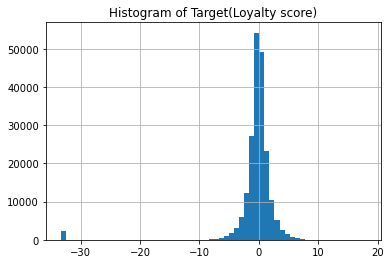

In [10]:
#plot histogram of target variable
plot_hist(data=train['target'],title='Histogram of Target(Loyalty score)')

<b>Observation:</b> We can see in table, feature_1,feature_2 and feature_3 has same distribution for train and test set
<p>for loyalty score, most of the values are ranging from -10 to +10 but as we can see in graph there are some outliers so we will remove such outliers. 

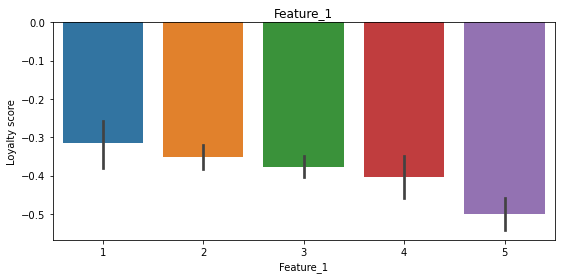

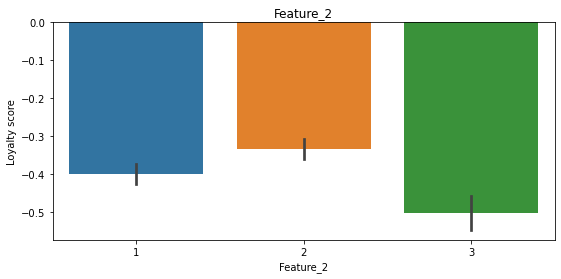

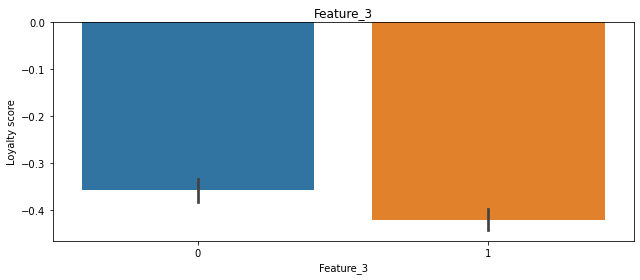

In [11]:
#Lets see if  can we predict loyalty  based on feature_{1,2,3}
plt.figure(figsize=(9,4))
sns.barplot(x="feature_1", y='target', data=train)
plt.xlabel('Feature_1')
plt.ylabel('Loyalty score')
plt.title("Feature_1")

plt.figure(figsize=(9,4))
sns.barplot(x="feature_2", y='target', data=train)
plt.xlabel('Feature_2')
plt.ylabel('Loyalty score')
plt.title("Feature_2")

plt.figure(figsize=(9,4))
sns.barplot(x="feature_3", y='target', data=train)
plt.xlabel('Feature_3')
plt.ylabel('Loyalty score')
plt.title("Feature_3")
plt.tight_layout()
plt.show()

<b>Observation:</b> If we see, loyalty score increasing as values of all three categories increasing except feature_2=2.

In [12]:
#Seperate outlier from train data
outlier = train[train['target']<=-30]
train = train[train['target']>-30]

In [13]:
print("Total outlier points(terget value is less than -30) are {}".format(outlier.shape[0]))
print("Percentage of outliers in train dataset {:.3f}".format(outlier.shape[0]/train.shape[0]*100))
outlier.shape,train.shape

Total outlier points(terget value is less than -30) are 2207
Percentage of outliers in train dataset 1.105


((2207, 6), (199710, 6))

<b>Observation:</b>
<p>In above plot we can see that there are some points whose target value is less than -30 and it seems like outlier.
<p>Lets see how many of points has target values less than -30
<p>There are total 2207 datapoints whose target value is lesss than and equal to -30. which is nothing but 1.093 percent of total train data.

Text(0.5, 1.0, 'Test')

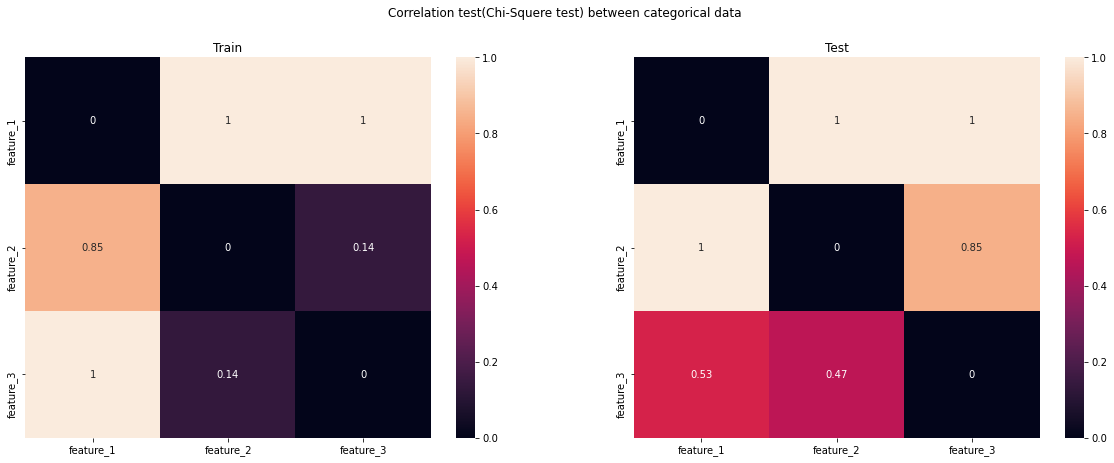

In [14]:
# Perform correlation between categorical data (feature_1,feature_2,feature_3) using chi square test
plt.figure(figsize=[20,7])
plt.suptitle('Correlation test(Chi-Squere test) between categorical data')
plt.subplot(1, 2, 1)
corr_between_category(train,['feature_1','feature_2','feature_3'])
plt.title('Train')

plt.subplot(1, 2, 2)
corr_between_category(test,['feature_1','feature_2','feature_3'])
plt.title('Test')

<b>Observation:</b> 
<p>In train set, all features are correlated with each other except feature_2 and feature _3(value is 0.14).
<p>In Test set, all features are hoghly correlated except feature_3 with feature_1 and feature_2(value is 0.53 and 0.47 respectively) which are less corelated.

<p>It is very difficult to predict the loyalty score just based of features given train set. We have merge data from merchants.csv, historical_transactions.csv and new_merchants_transactions.csv for better result.    

<h2> 3.2 Merchants Data</h2>

In [15]:
merchants = reduce_memory(pd.read_csv('data/merchants.csv'),df_name='merchant')
#we found that there are some inf values . so we will replace all inf values with null values
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)

Mem. usage decreased to 30.32 Mb (46.0% reduction) for merchant dataframe


<p>Total number of observations in train set are 334696 wih 22 features.
    
<p>Columns discription
<ol>
    <li><b>merchant_id</b>: Unique merchant identifier
    <li><b>merchant_group_id</b>: Merchant group (anonymized)
    <li><b>merchant_category_id</b>: Unique identifier for merchant category (anonymized)
    <li><b>subsector_id</b>: Merchant category group (anonymized)
    <li><b>numerical_1</b>: anonymized measure
    <li><b>numerical_2</b>: anonymized measure
    <li><b>category_1</b>: anonymized category
    <li><b>most_recent_sales_range</b>: Range of revenue (monetary units) in last active month --> A > B > C > D > E
    <li><b>most_recent_purchases_range</b>: Range of quantity of transactions in last active month --> A > B > C > D > E
    <li><b>avg_sales_lag3</b>: Monthly average of revenue in last 3 months divided by revenue in last active month
    <li><b>avg_purchases_lag3</b>: Monthly average of transactions in last 3 months divided by transactions in last active month
    <li><b>active_months_lag3</b>: Quantity of active months within last 3 months 
    <li><b>avg_sales_lag6</b>: Monthly average of revenue in last 6 months divided by revenue in last active month
    <li><b>avg_purchases_lag6</b>: Monthly average of transactions in last 6 months divided by transactions in last active month
    <li><b>active_months_lag6</b>: Quantity of active months within last 6 months
    <li><b>avg_sales_lag12</b>: Monthly average of revenue in last 12 months divided by revenue in last active month
    <li><b>avg_purchases_lag12</b>: Monthly average of transactions in last 12 months divided by transactions in last active month.
    <li><b>active_months_lag12</b>: Quantity of active months within last 12 months
    <li><b>category_4</b>: anonymized category 
    <li><b>city_id</b>: City identifier (anonymized)
    <li><b>state_id</b>: State identifier (anonymized)
    <li><b>category_2</b>: anonymized category
</ol>


In [16]:
# check if thr is any null values present in train and test or not 
calculate_null_values(merchants,'Merchants')

# # we found that there are some columsn whose value is Nan. There are totol 330k+ of datapoints so we can delete rows which has null value
merchants = merchants.dropna()

Check null values for Merchants dataframe
0 null values present in merchant_id
0 null values present in merchant_group_id
0 null values present in merchant_category_id
0 null values present in subsector_id
0 null values present in numerical_1
0 null values present in numerical_2
0 null values present in category_1
0 null values present in most_recent_sales_range
0 null values present in most_recent_purchases_range
13 null values present in avg_sales_lag3
3 null values present in avg_purchases_lag3
0 null values present in active_months_lag3
13 null values present in avg_sales_lag6
3 null values present in avg_purchases_lag6
0 null values present in active_months_lag6
13 null values present in avg_sales_lag12
3 null values present in avg_purchases_lag12
0 null values present in active_months_lag12
0 null values present in category_4
0 null values present in city_id
0 null values present in state_id
11887 null values present in category_2


In [17]:
merchants['avg_sales_lag3'].min(),merchants['avg_sales_lag6'].min(),merchants['avg_sales_lag12'].min()

(-82.13, -82.13, -82.13)

<p> Average sales cant be negative values. but as above we can see , there are some rows in which avg_sales_lag value is less than zero. It means these are outliers. We will drop such values

In [18]:
merchants = merchants.loc[(merchants['avg_sales_lag3'] >= 0) & (merchants['avg_sales_lag6'] >= 0) & (merchants['avg_sales_lag12'] >= 0)]

In [19]:
#check number of unique values in category columns
print('Total Unique values in merchant_category_id: {}'.format(len(merchants['merchant_category_id'].unique())))
print('Total Unique values in subsector_id: {}'.format(len(merchants['subsector_id'].unique())))
print('Total Unique values in category_1: {}'.format(len(merchants['category_1'].unique())))
print('Total Unique values in most_recent_sales_range: {}'.format(len(merchants['most_recent_sales_range'].unique())))
print('Total Unique values in most_recent_purchases_range: {}'.format(len(merchants['most_recent_purchases_range'].unique())))
print('Total Unique values in active_months_lag3: {}'.format(len(merchants['active_months_lag3'].unique())))
print('Total Unique values in active_months_lag6: {}'.format(len(merchants['active_months_lag6'].unique())))
print('Total Unique values in active_months_lag12: {}'.format(len(merchants['active_months_lag12'].unique())))
print('Total Unique values in category_4: {}'.format(len(merchants['category_4'].unique())))
print('Total Unique values in category_2: {}'.format(len(merchants['category_2'].unique())))

Total Unique values in merchant_category_id: 322
Total Unique values in subsector_id: 41
Total Unique values in category_1: 1
Total Unique values in most_recent_sales_range: 5
Total Unique values in most_recent_purchases_range: 5
Total Unique values in active_months_lag3: 3
Total Unique values in active_months_lag6: 6
Total Unique values in active_months_lag12: 12
Total Unique values in category_4: 2
Total Unique values in category_2: 5


In [20]:
print('99 percentile of avg_purchases_lag3',np.percentile(merchants['avg_purchases_lag3'],99))
print('100 percentile of avg_purchases_lag3',np.percentile(merchants['avg_purchases_lag3'],100))
print('-'*70)
print('99 percentile of avg_purchases_lag6',np.percentile(merchants['avg_purchases_lag6'],99))
print('100 percentile of avg_purchases_lag6',np.percentile(merchants['avg_purchases_lag6'],100))
print('-'*70)
print('99 percentile of avg_purchases_lag12',np.percentile(merchants['avg_purchases_lag12'],99))
print('100 percentile of avg_purchases_lag12',np.percentile(merchants['avg_purchases_lag12'],100))
print('-'*70)
print('99 percentile of avg_sales_lag3',np.percentile(merchants['avg_sales_lag3'],99))
print('100 percentile of avg_sales_lag3',np.percentile(merchants['avg_sales_lag3'],100))
print('-'*70)
print('99 percentile of avg_sales_lag6',np.percentile(merchants['avg_sales_lag6'],99))
print('100 percentile of avg_sales_lag6',np.percentile(merchants['avg_sales_lag6'],100))
print('-'*70)
print('99 percentile of avg_sales_lag12',np.percentile(merchants['avg_sales_lag12'],99))
print('100 percentile of avg_sales_lag12',np.percentile(merchants['avg_sales_lag12'],100))
print('-'*70)
print('99 percentile of numerical_1',np.percentile(merchants['numerical_1'],99))
print('100 percentile of numerical_1',np.percentile(merchants['numerical_1'],100))
print('-'*70)
print('99 percentile of numerical_2',np.percentile(merchants['numerical_2'],99))
print('100 percentile of numerical_2',np.percentile(merchants['numerical_2'],100))
print('-'*70)

99 percentile of avg_purchases_lag3 7.33333333
100 percentile of avg_purchases_lag3 61851.33333333
----------------------------------------------------------------------
99 percentile of avg_purchases_lag6 12.58366666340031
100 percentile of avg_purchases_lag6 56077.5
----------------------------------------------------------------------
99 percentile of avg_purchases_lag12 16.11111111
100 percentile of avg_purchases_lag12 50215.55555556
----------------------------------------------------------------------
99 percentile of avg_sales_lag3 10.720000267028809
100 percentile of avg_sales_lag3 851844.625
----------------------------------------------------------------------
99 percentile of avg_sales_lag6 18.620200805664247
100 percentile of avg_sales_lag6 1513959.0
----------------------------------------------------------------------
99 percentile of avg_sales_lag12 23.829999923706055
100 percentile of avg_sales_lag12 2567408.0
------------------------------------------------------------

<b>Observations:</b><p>In above cell we can see there are some extream points in numeric data. we will filter out and take only rows whose values are less than or equal to  99 percentile.

In [21]:
# filter merchants table from extream values
merchants = merchants.loc[(merchants['avg_purchases_lag3'] <= 6.33333333) & (merchants['avg_purchases_lag6'] <= 10.46947) & (merchants['avg_purchases_lag12'] <= 13.5) &
                          (merchants['avg_sales_lag3'] <= 9.0) & (merchants['avg_sales_lag6'] <= 14.80) & (merchants['avg_sales_lag12'] <= 19.05) &
                          (merchants['numerical_1'] <= 0.964) & (merchants['numerical_2'] <= 0.944)]

<p>After filtering data, we have total 323968 data points for merchants data

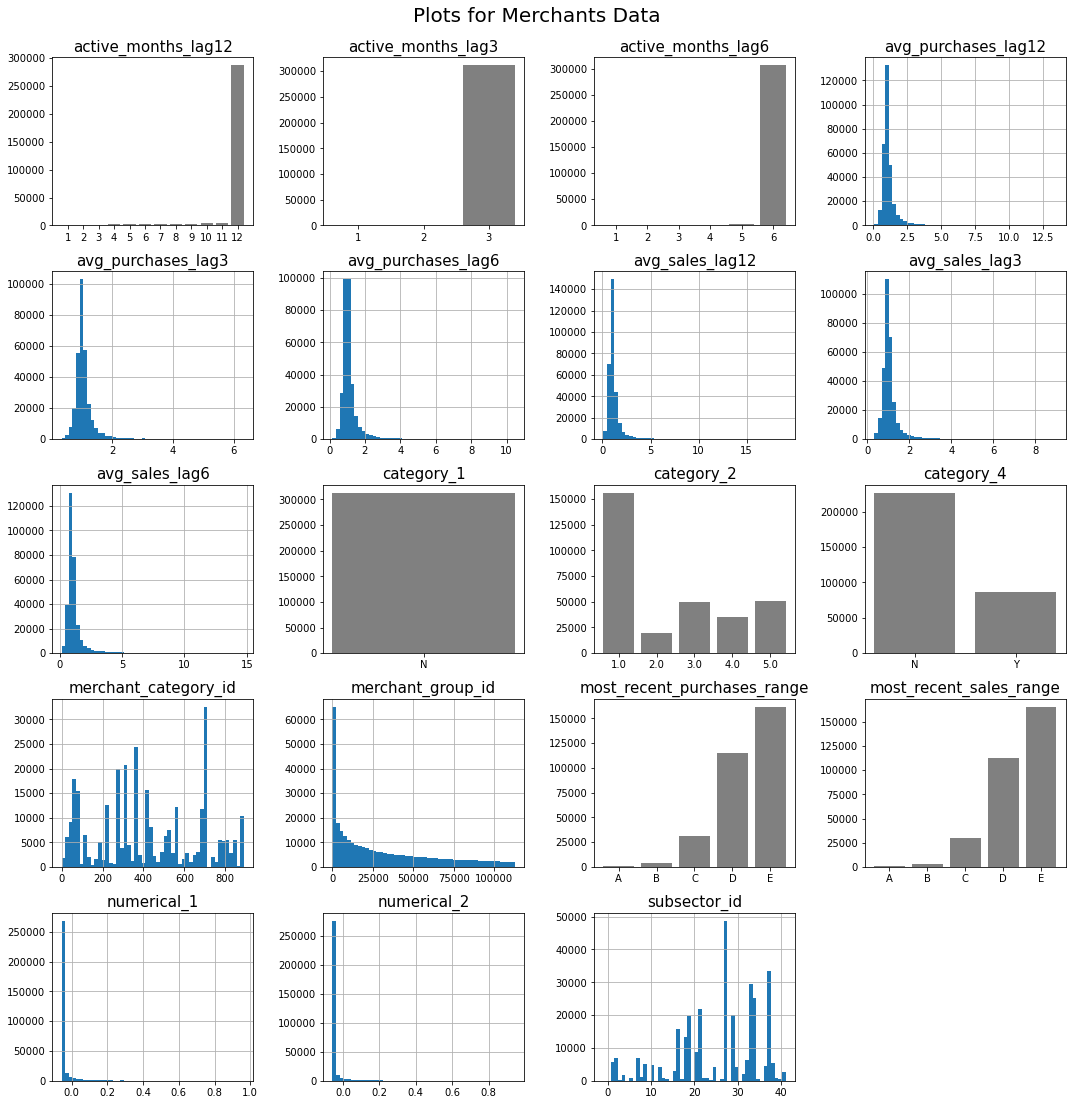

In [22]:
cat_features = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'active_months_lag3', 'active_months_lag6', 'active_months_lag12', 'category_4', 'category_2',]
num_features = ['merchant_group_id','merchant_category_id','numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3', 'subsector_id', 'avg_sales_lag6', 'avg_purchases_lag6', 'avg_sales_lag12', 'avg_purchases_lag12']
plot_hist_or_bar(data=merchants,title='Plots for Merchants Data',num_cols=num_features,cat_cols=cat_features)

In [23]:
print('Numerical_1 ',np.percentile(merchants['numerical_1'],90))
print('Numerical_2 ',np.percentile(merchants['numerical_2'],90))

Numerical_1  -0.0178070068359375
Numerical_2  -0.0277252197265625


<b>Observations:</b>
<li>Active_months_lag is most in last month of each Active_months_lag column.
<li>avg_sales_lag3 , avg_sales_lag6, avg_sales_lag12 by looking at these parameters , we can say that around 50% of merchants sales is constant(50% value appro 1.00)
<li>numerical_1 and numerical_2 has 90% of values less than 0.
<li>By looking at most_recent_purchase_range and most_recent_sales_range we can say sales is going in increasing order. 
<li> There are some extream points in numeric columns , so we will take 99 percentile of each numeric column.
<li>It looks that numerical_1 and numerical_2 are highly correlated with each other.

Text(0.5, 1.0, 'Correlation between numeric data(spearman) ')

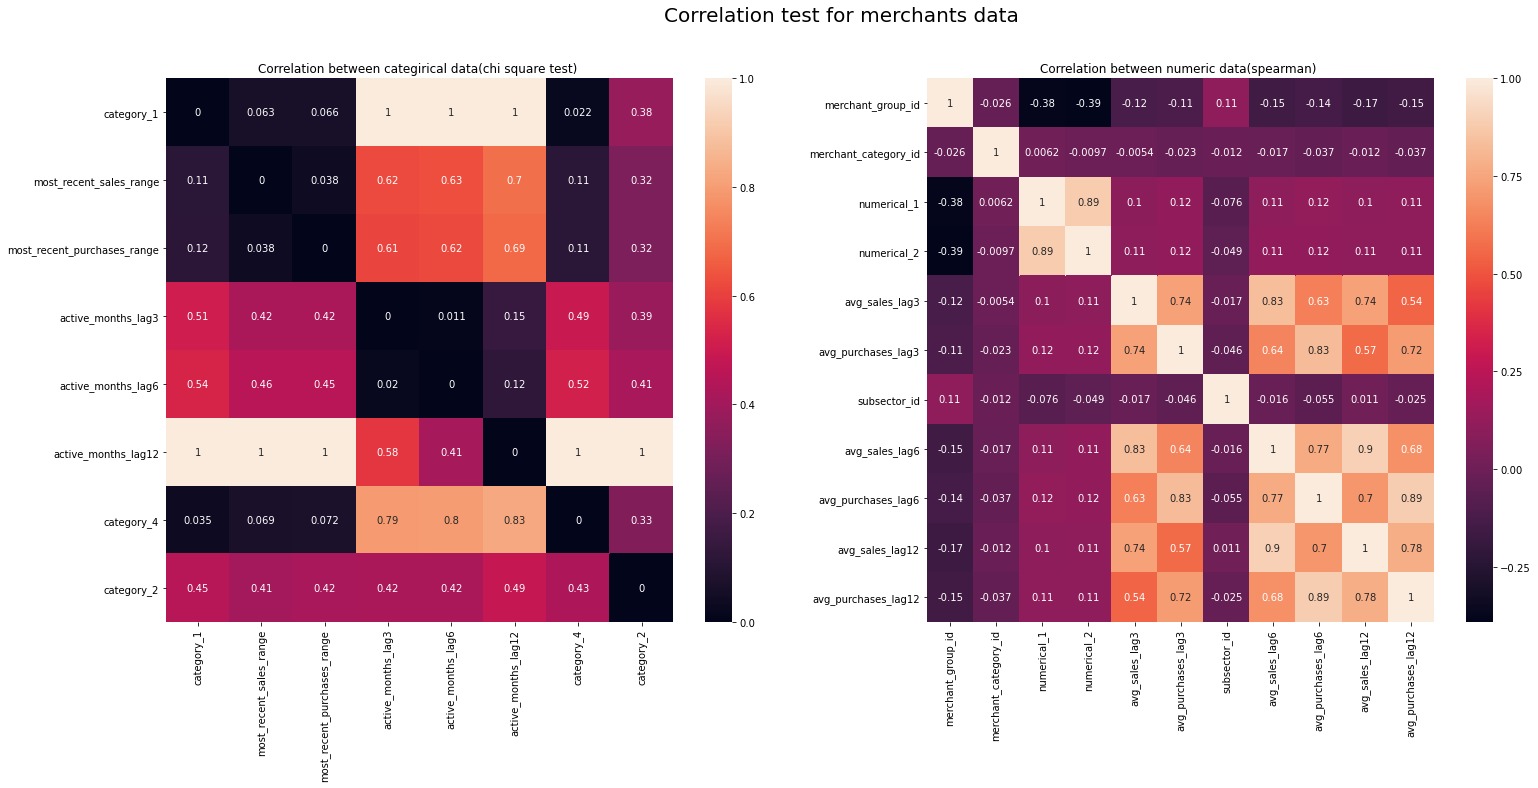

In [24]:
#Plot correlation between categorical features
plt.figure(figsize=[25,10])
plt.suptitle('Correlation test for merchants data',fontsize=20)
plt.subplot(1, 2, 1)
corr_between_category(merchants,cat_features)
plt.title('Correlation between categirical data(chi square test) ')

plt.subplot(1, 2, 2)
corr_between_numeric(merchants,num_features) # it might be possible that there is non linear ralationship between features . So we will use sperman correlation
plt.title('Correlation between numeric data(spearman) ')

<b>Observations:</b>
<li>For categorical features, category_1 is correlated with active_months. category_1, category_2, category_4, active_months_lag are correlated with each other.
<li>For numerical features, numerical_1 and numerical_2 are correlated with each other. avg_sales_lag3, avg_sales_lag6, avg_sales_lag12, avg_purchase_lag3, avg_purchase_lag6, avg_purchase_lag12 are hightly correlated with each other. subsector_id is not correlated with any feature so we can remove this feature.

<h2> 3.3 New Merchants Transactions Data</h2>

In [25]:
new_merchant_transactions = reduce_memory(pd.read_csv('data/new_merchant_transactions.csv'),df_name='new merchants')
#we found that there are some inf values . so we will replace all inf values with null values
new_merchant_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)



Mem. usage decreased to 114.20 Mb (45.5% reduction) for new merchants dataframe


<p>Total number of observations in train set are 1963031 wih 14 features.
    
<p>Columns discription
<ol>
    <li><b>authorized_flag</b>: 'Y' if approved, 'N' if denied
    <li><b>card_id</b>: Card identifier
    <li><b>city_id</b>: City identifier (anonymized)
    <li><b>category_1</b>: anonymized category
    <li><b>installments</b>: number of installments of purchase
    <li><b>category_3</b>: anonymized category
    <li><b>merchant_category_id</b>: Merchant category identifier (anonymized)
    <li><b>merchant_id</b>: Merchant identifier (anonymized)
    <li><b>month_lag</b>: month lag to reference date
    <li><b>purchase_amount</b>: Normalized purchase amount
    <li><b>purchase_date</b>: Purchase date
    <li><b>category_2</b>: anonymized category
    <li><b>state_id</b>: State identifier (anonymized)
    <li><b>subsector_id</b>:Merchant category group identifier (anonymized)
</ol>


In [26]:
#change data format for purchase data column
new_merchant_transactions['purchase_date'] = new_merchant_transactions['purchase_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [27]:
# check if thr is any null values present in train and test or not 
calculate_null_values(new_merchant_transactions,'New Merchants Transactions')

Check null values for New Merchants Transactions dataframe
0 null values present in authorized_flag
0 null values present in card_id
0 null values present in city_id
0 null values present in category_1
0 null values present in installments
55922 null values present in category_3
0 null values present in merchant_category_id
26216 null values present in merchant_id
0 null values present in month_lag
0 null values present in purchase_amount
0 null values present in purchase_date
111745 null values present in category_2
0 null values present in state_id
0 null values present in subsector_id


In [28]:
#check number of unique values in category columns
print('Total Unique values in category_1: {}'.format(len(new_merchant_transactions['category_1'].unique())))
print('Total Unique values in category_2: {}'.format(len(new_merchant_transactions['category_2'].unique())))
print('Total Unique values in category_3: {}'.format(len(new_merchant_transactions['category_3'].unique())))
print('Total Unique values in authorized_flag: {}'.format(len(new_merchant_transactions['authorized_flag'].unique())))
print('Total Unique values in installments: {}'.format(len(new_merchant_transactions['installments'].unique())))
print('Total Unique values in merchant_category_id: {}'.format(len(new_merchant_transactions['merchant_category_id'].unique())))
print('Total Unique values in month_lag: {}'.format(len(new_merchant_transactions['month_lag'].unique())))
print('Total Unique values in subsector_id: {}'.format(len(new_merchant_transactions['subsector_id'].unique())))

Total Unique values in category_1: 2
Total Unique values in category_2: 6
Total Unique values in category_3: 4
Total Unique values in authorized_flag: 1
Total Unique values in installments: 15
Total Unique values in merchant_category_id: 314
Total Unique values in month_lag: 2
Total Unique values in subsector_id: 41


In [29]:
print('99 percentile of purchase_amount',np.percentile(new_merchant_transactions['purchase_amount'],99))
print('100 percentile of purchase_amount',np.percentile(new_merchant_transactions['purchase_amount'],100))
print('-'*70)

99 percentile of purchase_amount 1.462890625
100 percentile of purchase_amount 263.25
----------------------------------------------------------------------


In [30]:
new_merchant_transactions[new_merchant_transactions['installments']>12]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
231851,Y,C_ID_8b3e96516a,174,N,999,C,840,M_ID_fcb061b2bf,1,-0.027145,2017-04-24 20:04:23,1.0,9,20
631387,Y,C_ID_726ae3c2bc,174,N,999,C,840,M_ID_fcb061b2bf,2,1.032227,2017-12-23 23:57:41,1.0,9,20


In [31]:
# There are total 55922 elements whose installments values is -1. And Installments value cant be less than 0.
# So we will remove such datapoints whose installment value is less than 0
new_merchant_transactions = new_merchant_transactions.loc[new_merchant_transactions['installments']>=0]

# there are some ourliers in installments columns. 2 rows has installments value 999 and max values is 12 except these 2 rows
# So we will delete such rows
new_merchant_transactions = new_merchant_transactions.loc[new_merchant_transactions['installments']<13]

# 99% percentile of purchase amount is 1.21 and max value is 263.25. it seems line thr are some extream outliers in average purchase amount
# Se we will delete such rows
new_merchant_transactions = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount']<1.21]

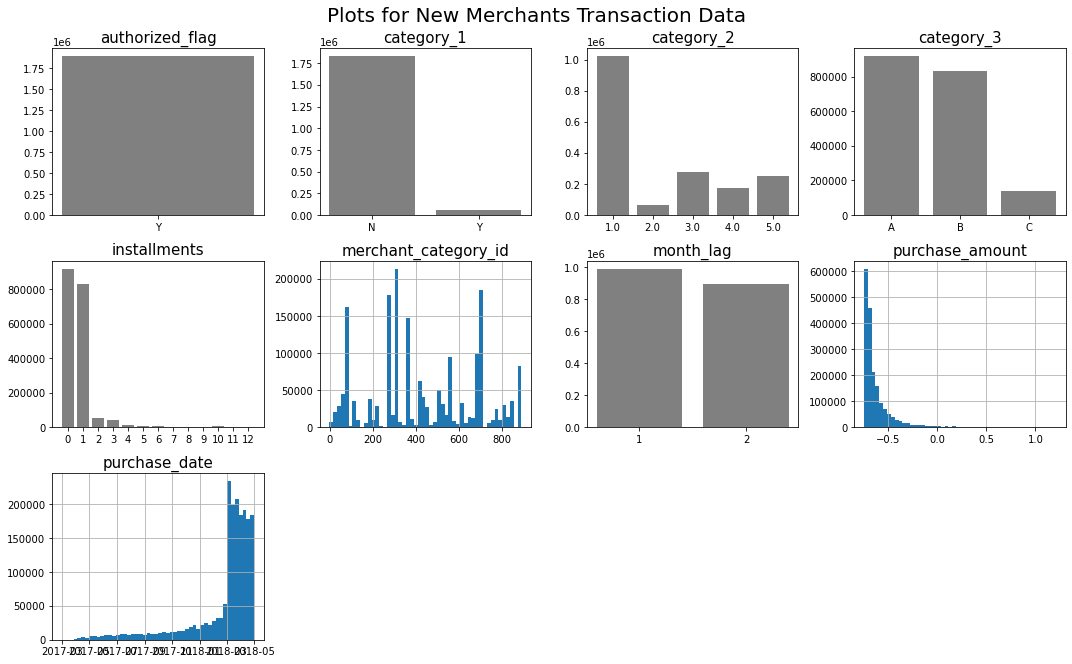

In [32]:
cat_features = ['category_1', 'category_2', 'category_3', 'authorized_flag', 'month_lag', 'installments',]
num_features = ['merchant_category_id','purchase_amount','purchase_date']
plot_hist_or_bar(data=new_merchant_transactions,title='Plots for New Merchants Transaction Data',num_cols=num_features,cat_cols=cat_features)

<b>Observations:</b>
<li>All autherized_flags are Y only.Means all transactions in new merchants are authorized so we can delete this row from final data.
<li>Around 96.6(1829695/1888122) percent of transactions are belong to 'N' type in category_1 and 54(1021814/1888122) percent are belong to '1' type in category_2.
<li>92.7((918880+832601)/1888122) percent of transactions has installments 0 or 1. 
<li>Month_lag is almost equally distributed for all transactions. 

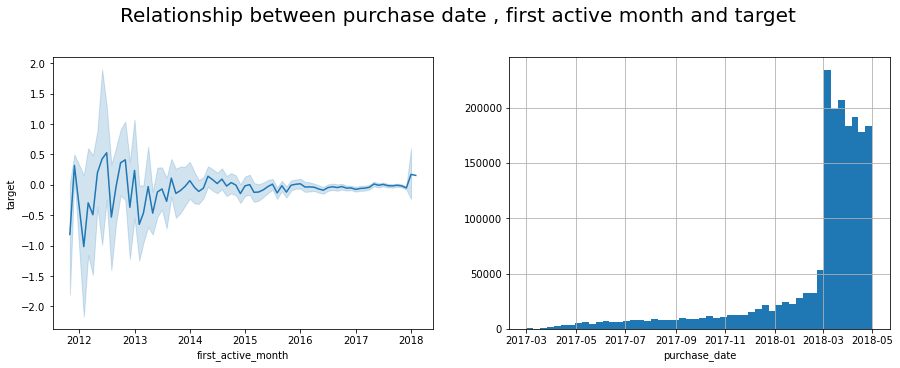

In [33]:
plt.figure(figsize=(15, 5))
plt.suptitle('Relationship between purchase date , first active month and target', y=1.02, fontsize=20)
plt.subplot(121)
sns.lineplot(x='first_active_month', y='target', data=train)
plt.subplot(122)
new_merchant_transactions['purchase_date'].hist(bins=50)
plt.xlabel('purchase_date')
plt.show()

<b>Observation:</b> In first plot(first_active_months vs target), loyalty score confidence interval is very less in 2017-2018 as compare to previous years. It means lots of cards got activated in 2017-2018. And in second graph we can see number of purchases increased in 2017-2018 . So we can conclude that loyalty score is related to number of purchases customer made. 

Text(0.5, 1.0, 'Correlation between numeric data(spearman) ')

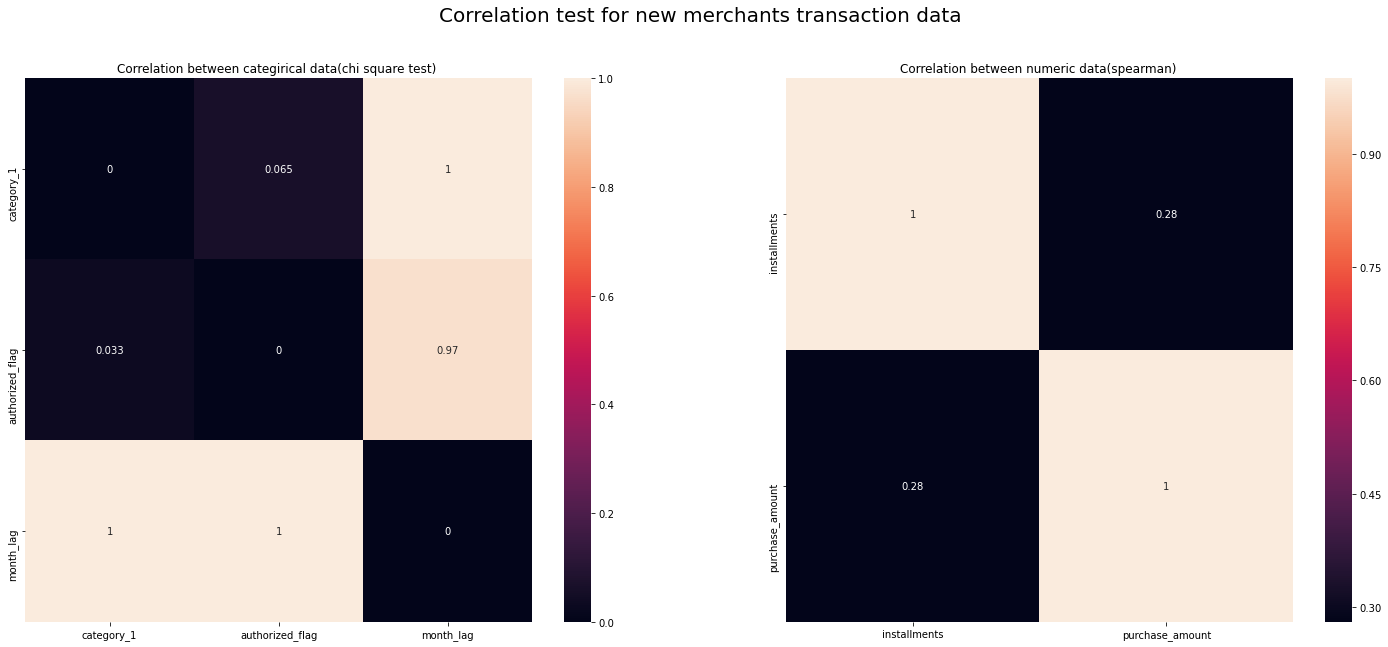

In [34]:
#Plot correlation between categorical features
plt.figure(figsize=[25,10])
plt.suptitle('Correlation test for new merchants transaction data',fontsize=20)
plt.subplot(1, 2, 1)
corr_between_category(new_merchant_transactions,['category_1', 'authorized_flag', 'month_lag',])
plt.title('Correlation between categirical data(chi square test) ')

plt.subplot(1, 2, 2)
corr_between_numeric(new_merchant_transactions,['installments','purchase_amount']) # it might be possible that there is non linear ralationship between features . So we will use sperman correlation
plt.title('Correlation between numeric data(spearman) ')

<b>Observations:</b>
<li>For categorical features, month_lag is highly correlated with category_1 and authorized_flag and category_1 is correlated with month_lag .
<li>For numerical features, both purchase_amound and installments are very less correlated with each other

<h2>3.3 Historical transaction Data</h2>

In [35]:
hist_transactions = reduce_memory(pd.read_csv('data/historical_transactions.csv'),df_name='Historical Transactions')
#we found that there are some inf values . so we will replace all inf values with null values
hist_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)


Mem. usage decreased to 1749.11 Mb (43.7% reduction) for Historical Transactions dataframe


<p>Total number of observations in train set are 29112361 wih 14 features.
    
<p>Columns discription
<ol>
    <li><b>authorized_flag</b>: 'Y' if approved, 'N' if denied
    <li><b>card_id</b>: Card identifier
    <li><b>city_id</b>: City identifier (anonymized)
    <li><b>category_1</b>: anonymized category
    <li><b>installments</b>: number of installments of purchase
    <li><b>category_3</b>: anonymized category
    <li><b>merchant_category_id</b>: Merchant category identifier (anonymized)
    <li><b>merchant_id</b>: Merchant identifier (anonymized)
    <li><b>month_lag</b>: month lag to reference date
    <li><b>purchase_amount</b>: Normalized purchase amount
    <li><b>purchase_date</b>: Purchase date
    <li><b>category_2</b>: anonymized category
    <li><b>state_id</b>: State identifier (anonymized)
    <li><b>subsector_id</b>:Merchant category group identifier (anonymized)
</ol>


In [36]:
#change data format for purchase data column
hist_transactions['purchase_date'] = hist_transactions['purchase_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [37]:
# check if thr is any null values present in train and test or not 
calculate_null_values(hist_transactions,'Historical Transactions')

Check null values for Historical Transactions dataframe
0 null values present in authorized_flag
0 null values present in card_id
0 null values present in city_id
0 null values present in category_1
0 null values present in installments
178159 null values present in category_3
0 null values present in merchant_category_id
138481 null values present in merchant_id
0 null values present in month_lag
0 null values present in purchase_amount
0 null values present in purchase_date
2652864 null values present in category_2
0 null values present in state_id
0 null values present in subsector_id


In [38]:
#check number of unique values in category columns
print('Total Unique values in category_1: {}'.format(len(hist_transactions['category_1'].unique())))
print('Total Unique values in category_2: {}'.format(len(hist_transactions['category_2'].unique())))
print('Total Unique values in category_3: {}'.format(len(hist_transactions['category_3'].unique())))
print('Total Unique values in authorized_flag: {}'.format(len(hist_transactions['authorized_flag'].unique())))
print('Total Unique values in installments: {}'.format(len(hist_transactions['installments'].unique())))
print('Total Unique values in merchant_category_id: {}'.format(len(hist_transactions['merchant_category_id'].unique())))
print('Total Unique values in month_lag: {}'.format(len(hist_transactions['month_lag'].unique())))
print('Total Unique values in subsector_id: {}'.format(len(hist_transactions['subsector_id'].unique())))

Total Unique values in category_1: 2
Total Unique values in category_2: 6
Total Unique values in category_3: 4
Total Unique values in authorized_flag: 2
Total Unique values in installments: 15
Total Unique values in merchant_category_id: 327
Total Unique values in month_lag: 14
Total Unique values in subsector_id: 41


In [39]:
# There are total 178159 elements whose installments values is -1. And Installments value cant be less than 0.
# So we will remove such datapoints whose installment value is less than 0
hist_transactions = hist_transactions.loc[hist_transactions['installments']>=0]

# there are some ourliers in installments columns. 188 rows has installments value 999 and max values is 12 except these 188 rows
# So we will delete such rows
hist_transactions = hist_transactions.loc[hist_transactions['installments']<13]

# 99% percentile of purchase amount is 1.22 and max value is 6010604.0. it seems like thr are some extream outliers in average purchase amount
# Se we will delete such rows
hist_transactions = hist_transactions.loc[hist_transactions['purchase_amount']<1.22]

<p>After preprocessing, there are total 28657333 left

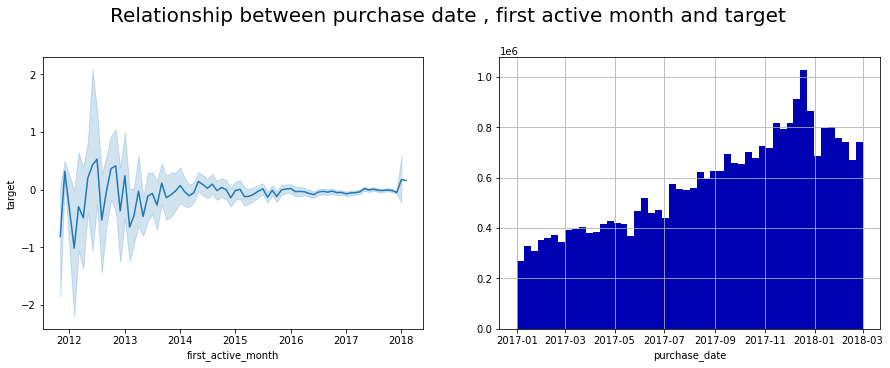

In [40]:
plt.figure(figsize=(15, 5))
plt.suptitle('Relationship between purchase date , first active month and target', y=1.02, fontsize=20)
plt.subplot(121)
sns.lineplot(x='first_active_month', y='target', data=train)
plt.subplot(122)
hist_transactions['purchase_date'].hist(bins=50,color=(0,0,0.7))
plt.xlabel('purchase_date')
plt.show()

<b>Observation:</b> In first plot(first_active_months vs target), loyalty score confidence interval is very less in 2017-2018 as compare to previous years. It means lots of cards got activated in 2017-2018. And in second graph we can see number of purchases increased in 2017-2018 . So we can conclude that loyalty score is related to number of purchases customer made. 
    

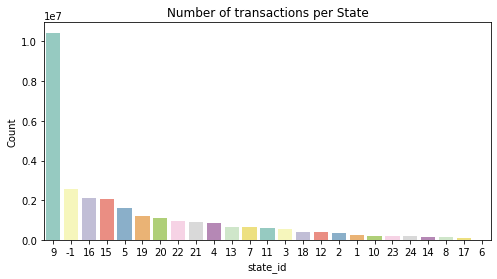

In [41]:
# check number of transactions per state 
plt.figure(figsize=(8, 4))
sns.countplot(x='state_id', data=hist_transactions,order=hist_transactions['state_id'].value_counts().index,palette="Set3")
plt.ylabel('Count')
plt.xlabel('state_id')
plt.title('Number of transactions per State')
plt.show()

<b>Observation: </b> Lots of tranasctions(36.4 percent) happened in state 9 

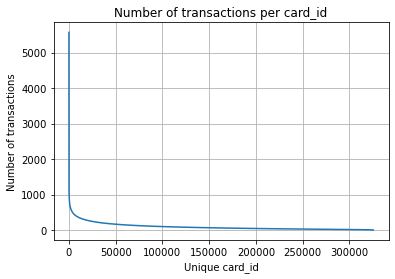

In [42]:
# Lets merge new and historical transactions
transactions = pd.concat([hist_transactions, new_merchant_transactions])
#LEt see number of transaction 
plt.grid()
plt.plot(transactions['card_id'].value_counts().values)
plt.xlabel('Unique card_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per card_id')
plt.show()

<b>Observations:</b> There are few card_ids who made lots of transactions.
<p>It might be possible that loyalty score is related to number of transactions and number of decline transactions. 

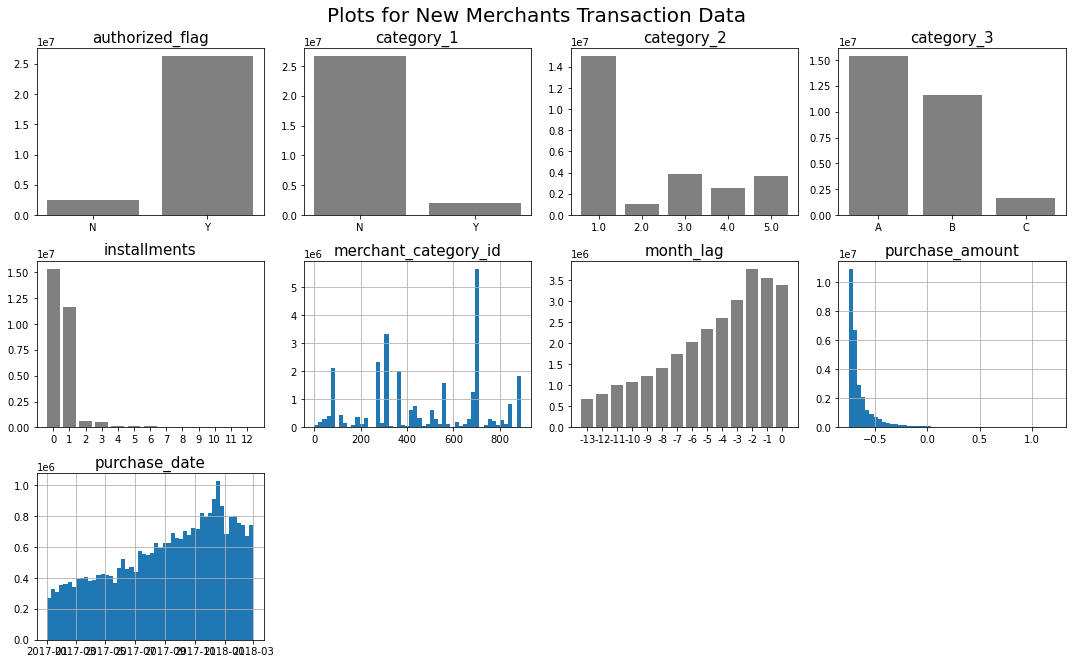

In [43]:
cat_features = ['category_1', 'category_2', 'category_3', 'authorized_flag', 'month_lag', 'installments',]
num_features = ['merchant_category_id','purchase_amount','purchase_date']
plot_hist_or_bar(data=hist_transactions,title='Plots for New Merchants Transaction Data',num_cols=num_features,cat_cols=cat_features)

<b>Observations:</b>
<li>There are some autorized and unautorized transactions. but there are 91.55%(26235810 / 28657333) are authorzed.
<li>Around 92.97(26641630 / 28657333) percent of transactions are belong to 'N' type in category_1 and 52.3 (14986115 / 28657333) percent are belong to '1' type in category_2.
<li>94.12((15355645+11615799) / 28657333) percent of transactions has installments 0 or 1. 


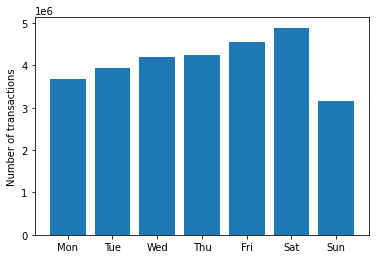

In [44]:
counts = (hist_transactions['purchase_date'].dt.dayofweek.value_counts())
plt.bar(x=counts.index, height=counts.values)
plt.ylabel('Number of transactions')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

<b>Observations:</b>Here we can see that there are very less transactions on sunday and peak on saturday.

Text(0.5, 1.0, 'Correlation between numeric data(spearman) ')

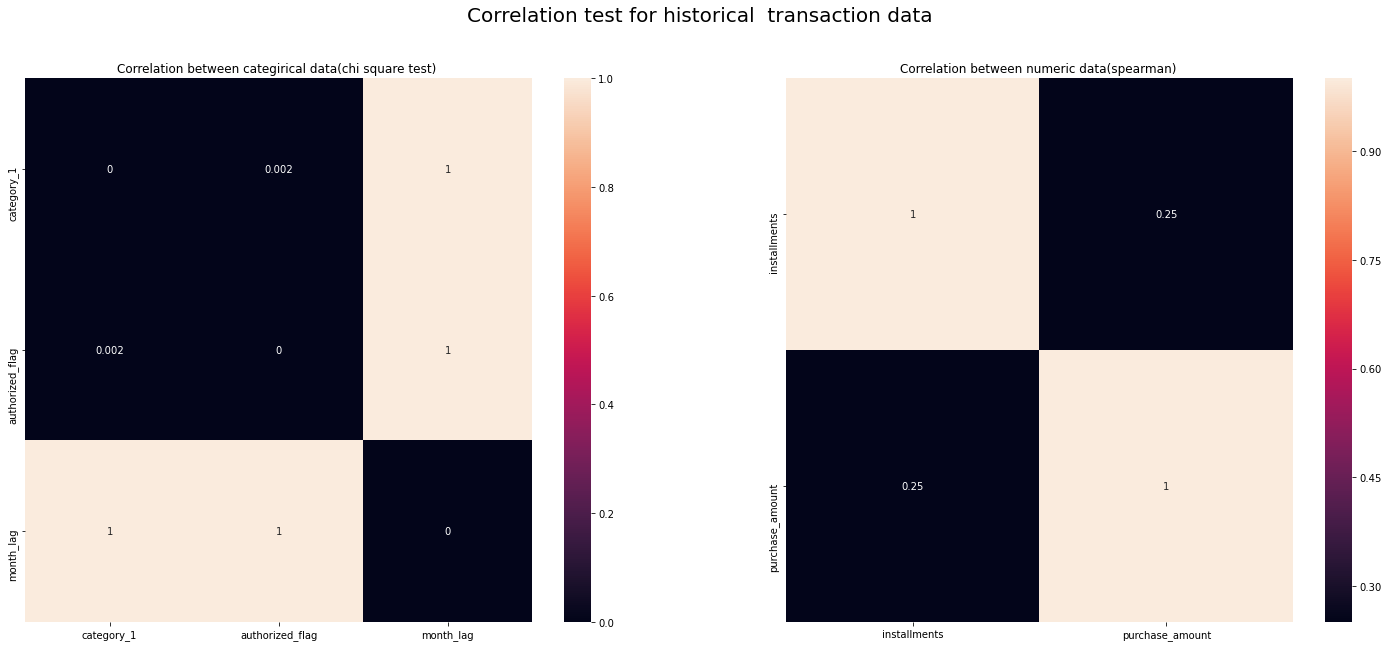

In [45]:
#Plot correlation between categorical features
plt.figure(figsize=[25,10])
plt.suptitle('Correlation test for historical  transaction data',fontsize=20)
plt.subplot(1, 2, 1)
corr_between_category(hist_transactions,['category_1', 'authorized_flag', 'month_lag',])
plt.title('Correlation between categirical data(chi square test) ')

plt.subplot(1, 2, 2)
corr_between_numeric(hist_transactions,['installments','purchase_amount']) # it might be possible that there is non linear ralationship between features . So we will use sperman correlation
plt.title('Correlation between numeric data(spearman) ')

<b>Observations:</b> Here also
<li>For categorical features, month_lag is highly correlated with category_1 and authorized_flag and category_1 is correlated with month_lag .
<li>For numerical features, both purchase_amound and installments are very less correlated with each other

## Lets do some analysis for outliers in target variable

In [49]:
outlier_card_id = list(outlier['card_id'].values)
outlier_hist_transactions = hist_transactions[hist_transactions['card_id'].isin(outlier_card_id)]
outlier_new_transactions = new_merchant_transactions[new_merchant_transactions['card_id'].isin(outlier_card_id)]

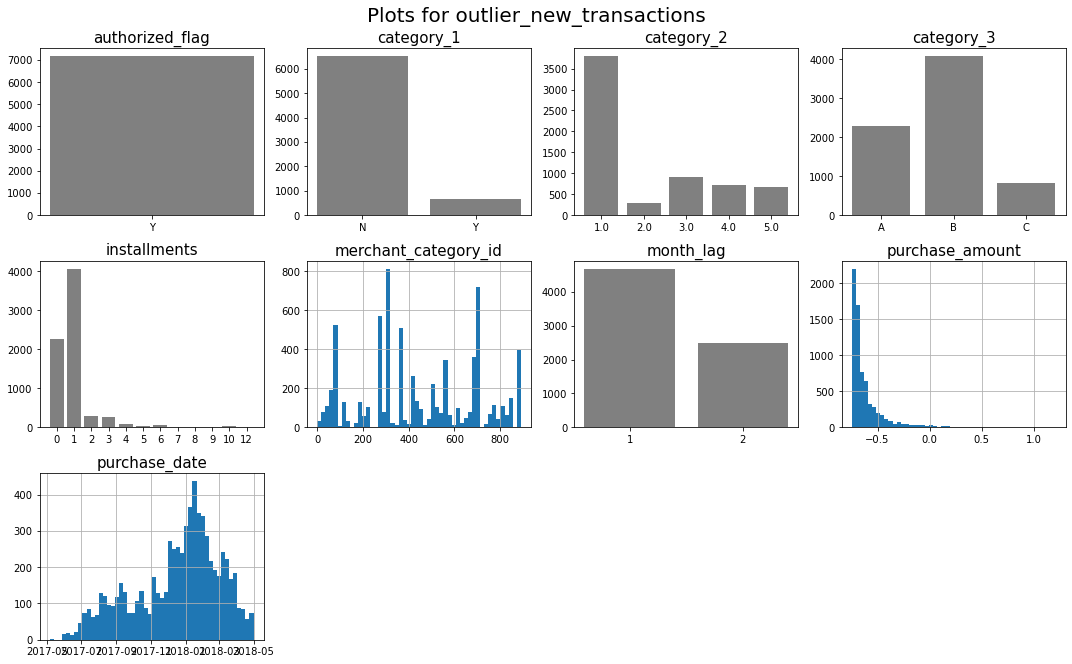

In [50]:
cat_features = ['category_1', 'category_2', 'category_3', 'authorized_flag', 'month_lag', 'installments',]
num_features = ['merchant_category_id','purchase_amount','purchase_date']
plot_hist_or_bar(data=outlier_new_transactions,title='Plots for outlier_new_transactions',num_cols=num_features,cat_cols=cat_features)

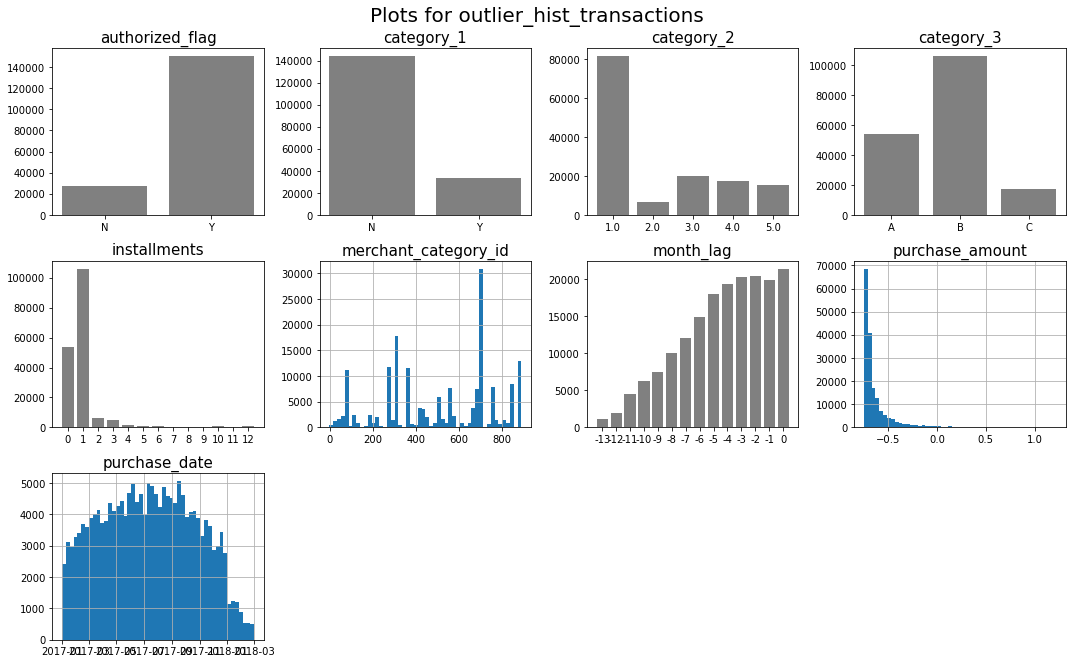

In [51]:
cat_features = ['category_1', 'category_2', 'category_3', 'authorized_flag', 'month_lag', 'installments',]
num_features = ['merchant_category_id','purchase_amount','purchase_date']
plot_hist_or_bar(data=outlier_hist_transactions,title='Plots for outlier_hist_transactions',num_cols=num_features,cat_cols=cat_features)

<b>Observations:</b>
<li>We have plot hitogram and bard graph for those whose target value is -33.
<li>By looking at graph, it is very difficult to tell for which feature it is causing target -33. and we are not able to judge so we will keep outlier in our train variable     

## Observations:

<li>Only train data is not enough for prediction for loyalty score.
<li>We have historical transactions and new transactions for each card Id. Hence we have to merge both tables so we can increase accuracy and reduce error as much as possible.
<li>We have to aggregate some features to create new features.
<li>We found some outlier in target varible and it might impact our model so we have removed such outliers to build robust model. We also found some extream points in numeric columns so we will remove such extream points.
<li>We have to handle missing value using standard imputation techniques.